### Colab-only

Install kubectl and Helm

In [ ]:
%cd /tools
!curl -O https://dl.google.com/dl/cloudsdk/channels/rapid/downloads/google-cloud-cli-linux-x86_64.tar.gz > /dev/null 2>&1
!tar -xf google-cloud-cli-linux-x86_64.tar.gz
!gcloud components install -q gke-gcloud-auth-plugin > /dev/null 2>&1
!gcloud components install -q kubectl > /dev/null 2>&1
!curl https://baltocdn.com/helm/signing.asc | gpg --dearmor | sudo tee /usr/share/keyrings/helm.gpg> /dev/null
!sudo apt-get install apt-transport-https --yes > /dev/null 2>&1
!echo "deb [arch=$(dpkg --print-architecture) signed-by=/usr/share/keyrings/helm.gpg] https://baltocdn.com/helm/stable/debian/ all main" | sudo tee /etc/apt/sources.list.d/helm-stable-debian.list
!sudo apt-get update > /dev/null 2>&1
!sudo apt-get install helm > /dev/null 2>&1
%cd /content

/tools
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1699  100  1699    0     0   9715      0 --:--:-- --:--:-- --:--:--  9764
deb [arch=amd64 signed-by=/usr/share/keyrings/helm.gpg] https://baltocdn.com/helm/stable/debian/ all main
/content


In [ ]:
# Colab-only
from google.colab import auth
auth.authenticate_user()

In [ ]:
# make sure we have a proper version of Dask
!pip install -q --upgrade "dask[complete]==2024.1.0"

In [ ]:
# make sure version printed below is 2024.1.0, if not - restart this session before running next cells
import dask
dask.__version__

'2024.1.0'

In [ ]:
PROJECT="dgena-demo2"
ZONE="us-east4-c"
CLUSTER='embeddings-cluster'

In [ ]:
!gcloud config set project $PROJECT

Updated property [core/project].


#### 1. Create a new GKE cluster

In [ ]:
%%time

# create cluster, this takes ~5 min
!gcloud container clusters create $CLUSTER \
    --zone=$ZONE \
    --num-nodes=2 \
    --machine-type=c2-standard-8

Default change: VPC-native is the default mode during cluster creation for versions greater than 1.21.0-gke.1500. To create advanced routes based clusters, please pass the `--no-enable-ip-alias` flag
Note: The Kubelet readonly port (10255) is now deprecated. Please update your workloads to use the recommended alternatives. See https://cloud.google.com/kubernetes-engine/docs/how-to/disable-kubelet-readonly-port for ways to check usage and for migration instructions.
Note: Your Pod address range (`--cluster-ipv4-cidr`) can accommodate at most 1008 node(s).
Created [https://container.googleapis.com/v1/projects/dgena-demo2/zones/us-east4-c/clusters/embeddings-cluster].
To inspect the contents of your cluster, go to: https://console.cloud.google.com/kubernetes/workload_/gcloud/us-east4-c/embeddings-cluster?project=dgena-demo2
kubeconfig entry generated for embeddings-cluster.
NAME                LOCATION    MASTER_VERSION      MASTER_IP     MACHINE_TYPE   NODE_VERSION        NUM_NODES  STAT

Inspect your cluster in GKE: https://console.cloud.google.com/kubernetes




#### 2. Deploy Dask to our cluster using Helm

In [ ]:
# save cluster credentials in ~/.kube/config so that local kubectl and helm commands can use it
!gcloud container clusters get-credentials $CLUSTER --project $PROJECT --zone $ZONE

Fetching cluster endpoint and auth data.
kubeconfig entry generated for embeddings-cluster.


In [ ]:
!kubectl get pods

No resources found in default namespace.


In [ ]:
# install Dask om our cluster
!helm install --repo https://helm.dask.org \
    --set worker.replicas=16 \
    --set scheduler.serviceType=NodePort --set webUI.serviceType=NodePort --set jupyter.enabled=false \
    my-dask dask > /dev/null

In [ ]:
# run this command a few times to see then pod VMs provisioned
!kubectl get pods

NAME                                READY   STATUS    RESTARTS   AGE
my-dask-scheduler-5f778c9c4-lc72v   1/1     Running   0          17s
my-dask-worker-64dd4775df-2slmd     1/1     Running   0          16s
my-dask-worker-64dd4775df-6b2wl     1/1     Running   0          16s
my-dask-worker-64dd4775df-6djfx     1/1     Running   0          16s
my-dask-worker-64dd4775df-br25p     1/1     Running   0          16s
my-dask-worker-64dd4775df-c9qqv     1/1     Running   0          16s
my-dask-worker-64dd4775df-cqm6r     1/1     Running   0          16s
my-dask-worker-64dd4775df-fdd2s     1/1     Running   0          16s
my-dask-worker-64dd4775df-hqgbm     1/1     Running   0          16s
my-dask-worker-64dd4775df-jdbkx     1/1     Running   0          17s
my-dask-worker-64dd4775df-lrf48     1/1     Running   0          16s
my-dask-worker-64dd4775df-q4zp6     1/1     Running   0          16s
my-dask-worker-64dd4775df-qk9bf     1/1     Running   0          16s
my-dask-worker-64dd4775df-w7l7h   

#### 3. Forward ports for Dask Scheduler and Dask UI

In [ ]:
# run this command, then open a terminal and run the command printed below to forward Dask Scheduler port to localhost:8081

!echo kubectl port-forward $(kubectl get pod --selector="app=dask,component=scheduler,release=my-dask" --output jsonpath='{.items[0].metadata.name}') 8081:8786

kubectl port-forward my-dask-scheduler-5f778c9c4-lc72v 8081:8786


In [ ]:
# run this command, then open a local terminal where you can open a browser window to redirect Dask UI to your local machine port

# query node name and port to forward for Dask UI
NODE_NAME=!kubectl get pod --selector="app=dask,component=scheduler,release=my-dask" --output jsonpath='{.items[0].spec.nodeName}'
NODE_NAME=NODE_NAME[0]
NODE_PORT=!kubectl get services --output jsonpath='{.items[1].spec.ports[1].nodePort}'
NODE_PORT=NODE_PORT[0]

# run commands printed below in your local shell to forward Dask UI ports to localhost:8080, enter ssh password when asked
!echo gcloud compute firewall-rules create allow-ssh-ingress-from-iap --direction=INGRESS --action=allow --rules=tcp:22 --source-ranges=35.235.240.0/20
!echo gcloud compute ssh --tunnel-through-iap $NODE_NAME -- -NL 8080:localhost:$NODE_PORT

gcloud compute firewall-rules create allow-ssh-ingress-from-iap --direction=INGRESS --action=allow --rules=tcp:22 --source-ranges=35.235.240.0/20
gcloud compute ssh --tunnel-through-iap gke-embeddings-cluster-default-pool-1afc1ef4-0g9j -- -NL 8080:localhost:30121


#### 4. Test it Dask works

In [ ]:
# check if we can connect to cluster and run jobs
from dask.distributed import Client
client = Client("tcp://127.0.0.1:8081")
client

/usr/local/lib/python3.10/dist-packages/distributed/client.py:1391: VersionMismatchWarning: Mismatched versions found

+-------------+--------+-----------+---------+
| Package     | Client | Scheduler | Workers |
+-------------+--------+-----------+---------+
| cloudpickle | 2.2.1  | 3.0.0     | 3.0.0   |
| msgpack     | 1.0.8  | 1.0.7     | 1.0.7   |
| numpy       | 1.26.4 | 1.26.3    | 1.26.3  |
| toolz       | 0.12.1 | 0.12.0    | 0.12.0  |
+-------------+--------+-----------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


<Client: 'tcp://10.88.0.6:8786' processes=16 threads=128, memory=501.63 GiB>

In [ ]:
import dask.array as da
x = da.random.random((10000, 10000), chunks=(1000, 1000))
x

dask.array<random_sample, shape=(10000, 10000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

In [ ]:
# use like numpy, run on Dask cluster
y = x + x.T
z = y[::2, 5000:].mean(axis=1)

z.compute() # observe parallel tasks in the Dask UI

array([1.00249147, 0.99777653, 1.00480839, ..., 0.99838245, 0.9968834 ,
       1.00165094])

Check https://docs.dask.org/en/latest/10-minutes-to-dask.html for an intro into Dask

### KMeans example


In [ ]:
# install dependencies locally
!pip install -q "dask-ml[complete]" zarr xarray gcsfs pandas

In [ ]:
# make sure to install packages via EXTRA_PIP_PACKAGES or as below, it takes a minute or so to install it on all nodes
from dask.distributed import PipInstall
plugin = PipInstall(packages=["dask-ml[complete]", "gcsfs", "zarr", "xarray"], pip_options=["--upgrade"])
client.register_worker_plugin(plugin)

<ipython-input-75-63fed4168e81>:4: DeprecationWarning: `Client.register_worker_plugin` has been deprecated; please use `Client.register_plugin` instead
  client.register_worker_plugin(plugin)
<ipython-input-75-63fed4168e81>:4: UserWarning: Registering a `SchedulerPlugin` as a worker plugin is not allowed, registering as a scheduler plugin instead. To register as a worker plugin, inherit from `WorkerPlugin`.
  client.register_worker_plugin(plugin)


In [ ]:
import dask_ml.datasets
import dask_ml.cluster
import matplotlib.pyplot as plt

In [ ]:
X, y = dask_ml.datasets.make_blobs(n_samples=100_000_000,
                                   chunks=10_000_000,
                                   random_state=0,
                                   centers=5)
X = X.persist()
X

dask.array<concatenate, shape=(100000000, 2), dtype=float64, chunksize=(10000000, 2), chunktype=numpy.ndarray>

In [ ]:
km = dask_ml.cluster.KMeans(n_clusters=5, init_max_iter=2, oversampling_factor=10)
km.fit(X)

/usr/local/lib/python3.10/dist-packages/dask/base.py:1481: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(


KMeans(init_max_iter=2, n_clusters=5, oversampling_factor=10)

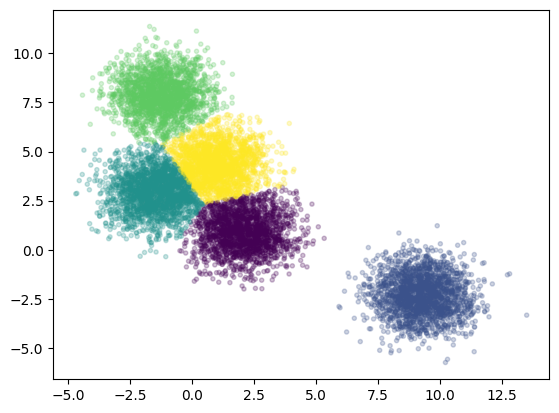

In [ ]:
fig, ax = plt.subplots()
ax.scatter(X[::10000, 0], X[::10000, 1], marker='.', c=km.labels_[::10000], cmap='viridis', alpha=0.25);

### Configure Impersonated GKE Cluster Access For kubectl if you want to access Google Cloud Services like Cloud Storage from GKE nodes

https://cloud.google.com/kubernetes-engine/docs/how-to/workload-identity

In [ ]:
SA="efm-dask-gke-test-sa"

In [ ]:
# create Google Cloud service account which will be bound to Kubernetes service account
!gcloud iam service-accounts create $SA --project=$PROJECT

Created service account [efm-dask-gke-test-sa].


In [ ]:
# bind necessary IAM roles to the GCP service account

!gcloud projects add-iam-policy-binding $PROJECT \
    --member "serviceAccount:"$SA"@"$PROJECT".iam.gserviceaccount.com" \
    --role "roles/storage.objectViewer"

gcloud projects add-iam-policy-binding dgena-demo2 --member serviceAccount:efm-dask-gke-test-sa@dgena-demo2.iam.gserviceaccount.com --role roles/storage.objectViewer
Updated IAM policy for project [dgena-demo2].
bindings:
- members:
  - serviceAccount:371815591318-compute@developer.gserviceaccount.com
  role: organizations/433637338589/roles/GceStorageAdmin
- members:
  - serviceAccount:service-371815591318@gcp-sa-aiplatform-cc.iam.gserviceaccount.com
  role: roles/aiplatform.customCodeServiceAgent
- members:
  - serviceAccount:service-371815591318@gcp-sa-aiplatform-vm.iam.gserviceaccount.com
  role: roles/aiplatform.notebookServiceAgent
- members:
  - serviceAccount:service-371815591318@gcp-sa-aiplatform.iam.gserviceaccount.com
  role: roles/aiplatform.serviceAgent
- members:
  - serviceAccount:service-371815591318@gcp-sa-artifactregistry.iam.gserviceaccount.com
  role: roles/artifactregistry.serviceAgent
- members:
  - serviceAccount:service-371815591318@gcp-sa-bigqueryconnection.iam

In [ ]:
# create Kubernetes service account for workload identity in the default namespace
!kubectl -n default create sa workload-sa

serviceaccount/workload-sa created


In [ ]:
# bind Kubernetes SA with GCP service account

!gcloud iam service-accounts add-iam-policy-binding \
    --role "roles/iam.workloadIdentityUser" \
    --member "serviceAccount:"$PROJECT".svc.id.goog[default/workload-sa]" \
    $SA"@"$PROJECT".iam.gserviceaccount.com"

Updated IAM policy for serviceAccount [efm-dask-gke-test-sa@dgena-demo2.iam.gserviceaccount.com].
bindings:
- members:
  - serviceAccount:dgena-demo2.svc.id.goog[default/workload-sa]
  role: roles/iam.workloadIdentityUser
etag: BwYhxhk_Wj4=
version: 1


In [ ]:
# annotate Kubernetes  SA
!kubectl -n default annotate serviceaccount workload-sa \
    iam.gke.io/gcp-service-account=$SA@$PROJECT.iam.gserviceaccount.com

serviceaccount/workload-sa annotated


In [ ]:
# ... access GCS from your cluster nodes here

#### 5. Clean up resources

In [ ]:
# uninstall dask
!helm uninstall my-dask

release "my-dask" uninstalled


In [ ]:
%%time

# ~3-4 min, make sure you run the first cell to define variables if you get an error here
!gcloud container clusters delete --quiet --zone=$ZONE $CLUSTER

ERROR:distributed.client:Failed to reconnect to scheduler after 30.00 seconds, closing client


Deleted [https://container.googleapis.com/v1/projects/dgena-demo2/zones/us-east4-c/clusters/embeddings-cluster].
CPU times: user 1.59 s, sys: 203 ms, total: 1.79 s
Wall time: 3min 14s
